Author: Geoff Boeing <br />
Web: http://geoffboeing.com/2015/03/chaos-theory-logistic-map/  <br />
Date: 2015-03-29 <br />
Description: This notebook demonstrates several ways to create Return Maps, or Poincaré Plots, to visualize system attractors and differentiate random noise from chaos. Return Maps embed 1-dimensional data (like time series) from a discrete dynamical system into 2- or 3-dimensional state space by plotting the value at time t vs the value at time t+1 (vs the value at time t+2, if it's a 3-D plot).

In [1]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import IPython.display as display

## The first 4 cells just define functions for our logistic map and Poincaré Plots

In [2]:
# for documentation of this function, see chaos-logistic-model.ipynb
def logistic_model(generations=20, growth_rate_min=0.5, growth_rate_max=4.0, growth_rate_steps=7, pop_initial=0.5):
    growth_rate_min = float(growth_rate_min)
    growth_rate_max = float(growth_rate_max) - 0.0000000001
    growth_rates = np.arange(growth_rate_min, growth_rate_max, (growth_rate_max - growth_rate_min) / growth_rate_steps)
    pops = pd.DataFrame(columns=growth_rates, index=range(generations))
    pops.iloc[0] = pop_initial
    for rate in pops.columns:
        pop = pops[rate]
        for t in range(generations - 1):
            pop[t + 1] = pop[t] * rate * (1 - pop[t])
    return pops

In [3]:
def get_poincare_points(pops, discard_gens=1, dimensions=2):
    """
    convert a dataframe of values from the logistic model into a set of xy(z) points to plot
    
    pops = population data output from the model
    discard_gens = number of rows to discard before keeping points to plot
    dimensions = 2 or 3, if we want points for a 2-D or 3-D plot
    """
    
    # drop the first row because every run has the same starting value, it leaves a visual artifact
    # drop the initial rows of the populations data, if specified by the argument
    if discard_gens > 0:
        discard_gens = np.arange(0, discard_gens)
        pops = pops.drop(labels=pops.index[discard_gens])
    
    # a point is defined by the name of its model run then its spatial coordinates
    points = []
    point_columns = ['name', 'x', 'y', 'z']
    
    # for each column in the logistic populations dataframe, where the label is the 'name' of the model run
    for name in pops.columns:
        
        # for each row in the column
        for label, row in pops.iterrows():
            
            # we can only create points up up to row dimensions-1 because we need future time steps to create each point
            if label < len(pops)-(dimensions-1):
                
                point = [name]
                for n in range(dimensions):
                    # append the value at the current time (aka row) as x, t+1 as y (and t+2 as z if dimensions=3)
                    point.append(pops[name][label + n])
                
                # append this point to the list of points
                points.append(point)
    
    # convert the list of points to a MultiIndex DataFrame 
    # with a level in the index called 'name' to represent each model run
    df = pd.DataFrame(points, columns=point_columns[0:dimensions+1])
    df.index = pd.MultiIndex.from_tuples(zip(df['name'], df.index), names=['name', ''])
    df = df.drop(labels='name', axis=1)
    return df

In [4]:
def poincare_plot(pops, discard_gens=1, height=6, width=6, xmin=0, xmax=1, ymin=0, ymax=1,
                  title=u'Poincaré Plot', xlabel='Population (t)', ylabel='Population (t + 1)',
                  marker='.', size=5, alpha=0.7, color='r', color_list=[], legend=False):
    
    # first get the xy points to plot
    points = get_poincare_points(pops, discard_gens, dimensions=2)
    plots = []
    
    # get_poincare_points() returns a MultiIndexed DataFrame, each run of the model has its own 'name' in the index
    index = points.index.get_level_values('name')
    names = np.unique(index)
    
    # add a color to the list for each run of the model if list doesn't have the same length as the number of runs
    # that way, each model run scatterplot gets a color, and we default to 'r' if color_list isn't passed or long enough
    color_list = [color for n in range(len(names))] if len(color_list) < len(names) else color_list
    
    # create a new matplotlib figure and axis and set its size
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    
    # set the plot title, x- and y-axis limits, and x- and y-axis labels
    ax.set_title(title)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    # plot the xy data for each run of the model that appears in the MultiIndex
    for n in range(len(names)):
        xy = points.iloc[index == names[n]]
        plots.append(ax.scatter(xy['x'], xy['y'], marker=marker, c=color_list[n], edgecolor='none', s=size, alpha=alpha))
        
    # add a legend if argument is True
    if legend:
        ax.legend(plots, names.tolist(), loc=1, frameon=True, framealpha=1)
        
    plt.show()

In [5]:
def poincare_plot_3d(pops, discard_gens=1, height=8, width=10, 
                     xmin=0, xmax=1, ymin=0, ymax=1, zmin=0, zmax=1,
                     title=u'3-D Poincaré Plot', elev=25, azim=240, dist=10,
                     xlabel='Population (t)', ylabel='Population (t + 1)', zlabel='Population (t + 2)',
                     marker='.', size=5, alpha=0.7, color='r', color_list=[], legend=False,
                     legend_bbox_to_anchor=None):
    
    # first get the xyz points to plot
    points = get_poincare_points(pops, discard_gens, dimensions=3)
    plots = []
    
    # get_poincare_points() returns a MultiIndexed DataFrame, each run of the model has its own 'name' in the index
    index = points.index.get_level_values('name')
    names = np.unique(index)
    
    # add a color to the list for each run of the model if list doesn't have the same length as the number of runs
    # that way, each model run scatterplot gets a color, and we default to 'r' if color_list isn't passed or long enough
    color_list = [color for n in range(len(names))] if len(color_list) < len(names) else color_list
    
    # create a new figure, set its size, and create an axis with a 3-D projection
    fig = plt.figure(figsize=(width, height))
    ax = fig.gca(projection='3d')

    # configure the perspective from which to view the 3D plot
    ax.elev = elev
    ax.azim = azim
    ax.dist = dist
    
    # set the plot title, axis limits, and axis labels
    ax.set_title(title)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)  
    ax.set_zlabel(zlabel)
    
    # plot the xyz data for each run of the model that appears in the MultiIndex
    for n in range(len(names)):
        xyz = points.iloc[index == names[n]]
        plots.append(ax.scatter(xyz['x'], xyz['y'], xyz['z'], 
                                marker=marker, c=color_list[n], edgecolor=color_list[n], s=size, alpha=alpha))
        
    # add a legend if argument is True
    if legend:
        ax.legend(plots, names.tolist(), loc=1, frameon=True, framealpha=1, bbox_to_anchor=legend_bbox_to_anchor)
        
    plt.show()

## First, let's a create Poincaré Plot to show the logistic map's fixed-point attractor at 0.655 when the growth rate parameter is set to 2.9

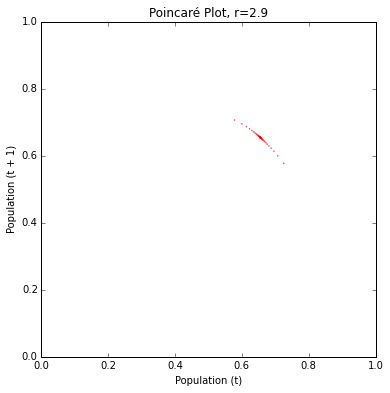

In [6]:
# draw a poincare plot for 100 generations for the growth rate parameter 2.9
# it shows points converging on 0.655 because the logistic map has a fixed-point attractor at 0.655 when r=2.9
generations = 100
growth_rate_min = 2.9
growth_rate_max = 4.0
growth_rate_steps = 1
pops = logistic_model(generations, growth_rate_min, growth_rate_max, growth_rate_steps)
poincare_plot(pops, title=u'Poincaré Plot, r=2.9', size=10)

## Next, let's create Poincaré Plots to show the logistic map's limit cycle attractor when the growth rate parameter is set to 3.2 or 3.5

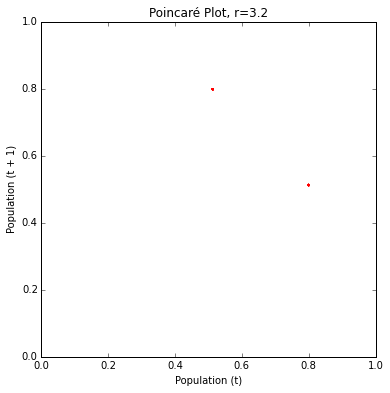

In [7]:
# draw a poincare plot for 100 generations for the growth rate parameter 3.2
# it shows 2 points because the logistic map has a period of 2 when r=3.2
generations = 100
growth_rate_min = 3.2
growth_rate_max = 4.0
growth_rate_steps = 1
pops = logistic_model(generations, growth_rate_min, growth_rate_max, growth_rate_steps)
poincare_plot(pops, title=u'Poincaré Plot, r=3.2', size=20)

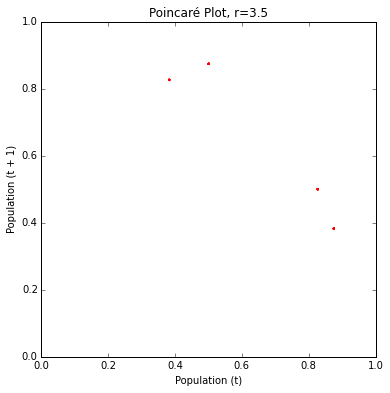

In [8]:
# draw a poincare plot for 100 generations for the growth rate parameter 3.5
# it shows 4 points because the logistic map has a period of 4 when r=3.5
generations = 100
growth_rate_min = 3.5
growth_rate_max = 4.0
growth_rate_steps = 1
pops = logistic_model(generations, growth_rate_min, growth_rate_max, growth_rate_steps)
poincare_plot(pops, title=u'Poincaré Plot, r=3.5', size=20)

## Now, let's create a Poincaré Plot to show the logistic map's strange attractor when the growth rate parameter is set to 3.9

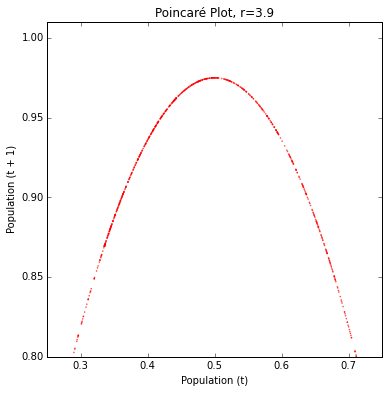

In [9]:
# draw a poincare plot for 2,000 generations for the growth rate parameter 3.9
# the plot reveals the strange attractor - the logistic map is chaotic when r=3.9
generations = 2000
growth_rate_min = 3.9
growth_rate_max = 4.0
growth_rate_steps = 1
pops = logistic_model(generations, growth_rate_min, growth_rate_max, growth_rate_steps)
poincare_plot(pops, xmin=0.25, xmax=0.75, ymin=0.8, ymax=1.01, size=10, title=u'Poincaré Plot, r=3.9')

## Now, let's create a Poincaré Plot to show the logistic map's strange attractors across the chaotic regime (from r=3.6 to r=4.0)

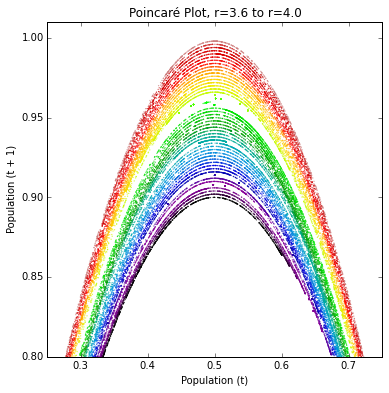

In [10]:
# draw a poincare plot for 1,000 generations across 50 growth rate steps from 3.6 to 4.0
# each chaotic growth rate has its own parabola
generations = 2000
growth_rate_min = 3.6
growth_rate_max = 4.0
growth_rate_steps = 50
pops = logistic_model(generations, growth_rate_min, growth_rate_max, growth_rate_steps)

# get range of colors, one for each growth rate the model ran
colors = cm.get_cmap('spectral')([x/float(growth_rate_steps) for x in range(growth_rate_steps)]).tolist()
poincare_plot(pops, xmin=0.25, xmax=0.75, ymin=0.8, ymax=1.01, size=7, 
              title=u'Poincaré Plot, r=3.6 to r=4.0', color_list=colors)

## Next, let's demonstrate how to use Poincaré Plots to differentiate chaos from random noise in time series data

In [11]:
# sometimes it is hard to tell if a time series is chaotic or random
# generate two time series of 1000 steps, one chaotic and one random
gens = 30000
chaos_pops = logistic_model(gens, 3.999, 4.0, 1)
chaos_pops = chaos_pops.iloc[gens-1000:].reset_index().drop(labels='index', axis=1)
random_pops = pd.DataFrame([random.random() for _ in range(0, 1000)], columns=['value'])
time_series = pd.concat([chaos_pops, random_pops], axis=1)
time_series.columns = ['chaos', 'random']
time_series.iloc[900:905]

,chaos,random
900,0.627054,0.609335
901,0.9351953,0.768968
902,0.2423597,0.310326
903,0.7343024,0.257306
904,0.7802145,0.344893


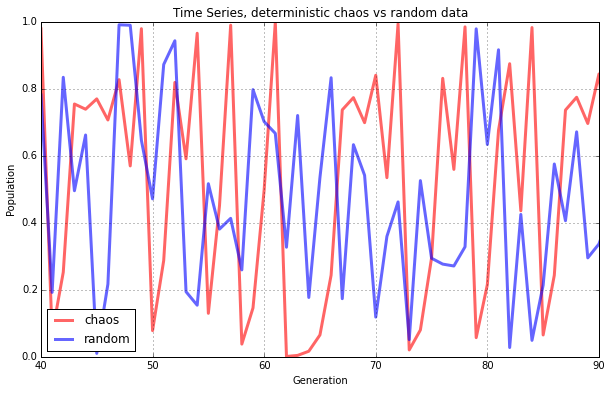

In [12]:
# plot the chaotic and random time series to show how they are sometimes tough to differentiate
ax = time_series.plot(kind='line', figsize=[10, 6], linewidth='3', alpha=0.6, style=['r-', 'b-'])
ax.set_xlim(40, 90)
ax.set_ylim(0, 1)
ax.set_title('Time Series, deterministic chaos vs random data')
ax.set_xlabel('Generation')
ax.set_ylabel('Population')
ax.legend(loc=3, frameon=True, framealpha=1)
plt.show()

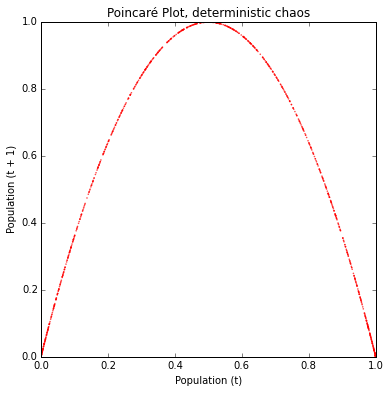

In [13]:
# draw a poincare plot the chaotic time series to show its strange attractor
poincare_plot(chaos_pops, size=10, title=u'Poincaré Plot, deterministic chaos')

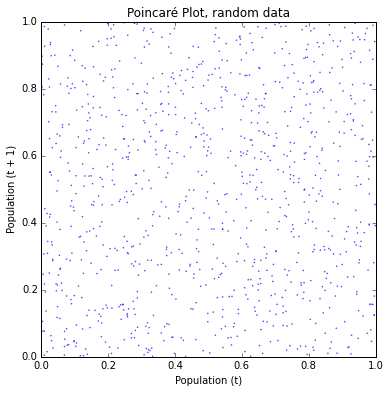

In [14]:
# now draw a poincare plot for the random time series to show it's just noise, no attractor
poincare_plot(random_pops, size=10, title=u'Poincaré Plot, random data', color='b')

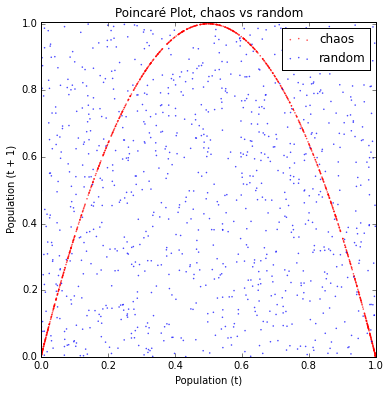

In [15]:
# or do them both together in one plot
pops = pd.concat([chaos_pops, random_pops], axis=1)
pops.columns = ['chaos', 'random']
poincare_plot(pops, size=10, color_list=['r', 'b'], title=u'Poincaré Plot, chaos vs random', ymax=1.005, legend=True)

## Now, let's create 3-D Poincaré Plots to show the same chaos vs random noise, in three dimensions

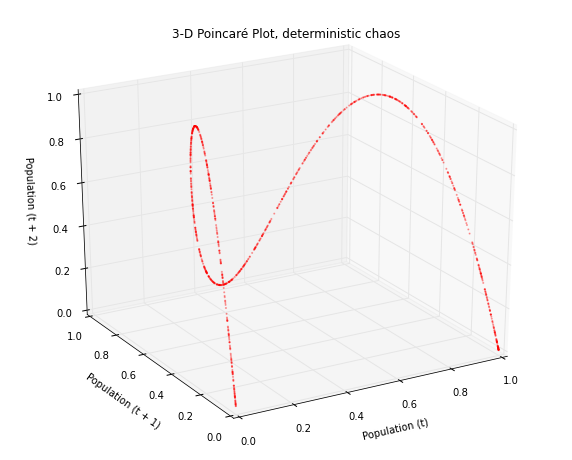

In [16]:
# the strange attractor looks even more interesting when it's plotted in a 3-D Poincare plot
# embed the 1-D time series data in 3-D state space by plotting pop at time t vs t+1 vs t+2
poincare_plot_3d(chaos_pops, title=u'3-D Poincaré Plot, deterministic chaos', alpha=0.3)

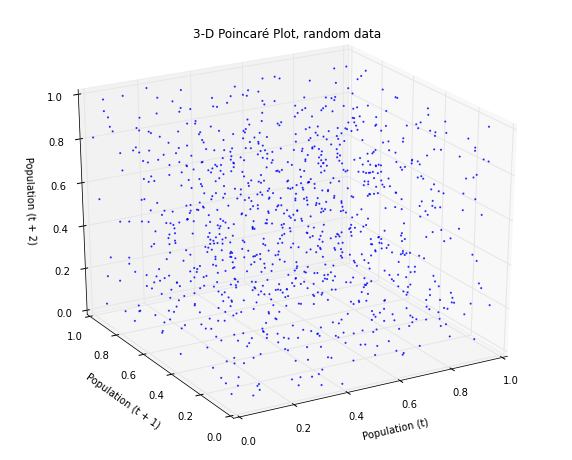

In [17]:
# in comparison, here's the poincare plot of the random data - it just looks like noise
poincare_plot_3d(random_pops, title=u'3-D Poincaré Plot, random data', color='b', alpha=0.7)

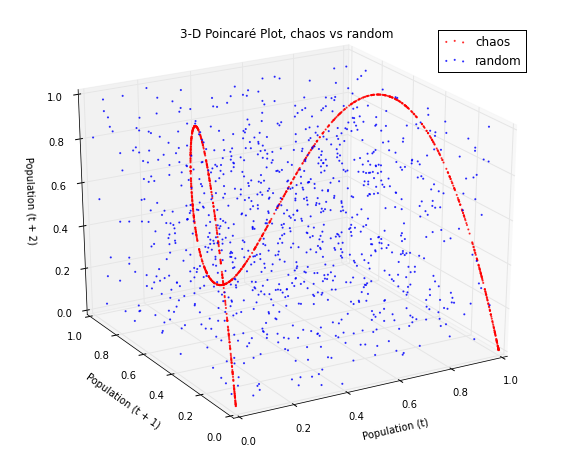

In [18]:
# or do them both together in one plot
pops = pd.concat([chaos_pops, random_pops], axis=1)
pops.columns = ['chaos', 'random']
poincare_plot_3d(pops, color_list=['r', 'b'], title=u'3-D Poincaré Plot, chaos vs random',
                 legend=True, legend_bbox_to_anchor=(0.94, 0.96))

## Create a 3-D Poincaré Plot to show the logistic map's strange attractors across the chaotic regime (from r=3.6 to r=4.0), twisting and curling around their state space in three dimensions

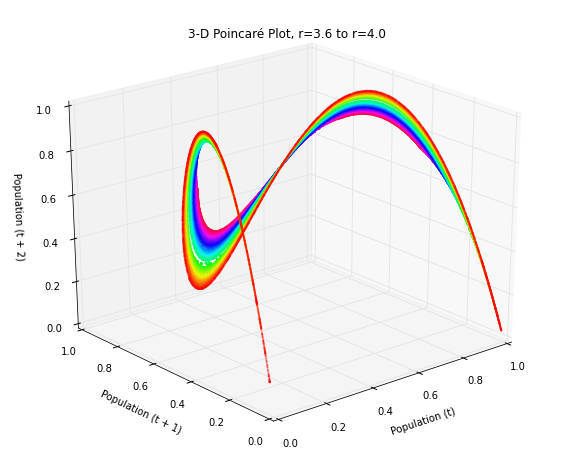

In [19]:
# create a 3-D poincare plot for 4,000 generations across 50 growth rate steps from 3.6 to 4.0
# each chaotic growth rate has its own strange attractor curling through state space
generations = 4000
growth_rate_min = 3.6
growth_rate_max = 4.0
growth_rate_steps = 50
pops = logistic_model(generations, growth_rate_min, growth_rate_max, growth_rate_steps)

# get a range of colors, one for each growth rate the model ran
colors = cm.get_cmap('hsv')([x/float(growth_rate_steps) for x in range(growth_rate_steps)]).tolist()
colors.reverse()

# draw the plot
poincare_plot_3d(pops, title=u'3-D Poincaré Plot, r=3.6 to r=4.0', alpha=0.1, color_list=colors, azim=230)

## In another notebook, I create animated gifs by panning and rotating around my 3-D Poincaré Plots to reveal even more of their beautiful structure:
http://nbviewer.ipython.org/github/gboeing/chaos-models/blob/master/chaos-animated-3d-plots.ipynb

In [20]:
# here's an example of the animated Poincaré Plots that I create in chaos-animated-3d-plots.ipynb
display.Image(url='images/multiple-chaos-return-map.gif')

## For more information about chaos theory, the logistic map, bifurcation plots, Poincaré plots, and strange attractors, check out my write-up:
http://geoffboeing.com/2015/03/chaos-theory-logistic-map/